In [48]:
import os 
import math
import requests

import pandas as pd 
import numpy as np 
import seaborn as sns
from collections import defaultdict
from string import punctuation
from parsivar import Tokenizer, Normalizer, FindStems


from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, recall_score

In [2]:
LABELS = {
    "اجتماعی" : "social",
    "اديان" : "religion",
    "اقتصادی" : "economics",
    "سیاسی" : "politics",
    "فناوري" : "technology" ,
    "مسائل راهبردي ايران" : "strategic" ,
    "ورزشی" : "sport",
}

In [3]:
persian = requests.get('https://raw.githubusercontent.com/kharazi/persian-stopwords/master/persian').text.split('\n')
verbal = requests.get('https://raw.githubusercontent.com/kharazi/persian-stopwords/master/verbal').text.split('\n')
nonverbal = requests.get('https://raw.githubusercontent.com/kharazi/persian-stopwords/master/nonverbal').text.split('\n')

stop_words = persian + verbal + nonverbal

In [4]:
train_texts = []
train_labels = []

test_texts = []
test_labels = []

def extract_texts (root, label , file, is_train) :
    path = root + '/' + file 
    with open(path,'r',encoding="utf-8") as f : 
        text = f.read()
        
        if is_train :
            train_texts.append(text)
            train_labels.append(LABELS[label])
        else :
            test_texts.append(text)
            test_labels.append(LABELS[label])

In [5]:
for (root,dirs,files) in os.walk('./Final_Dataset/Train') :
    
    if len(files) == 0 :
        continue
    for f in files :
        label = root.split('\\')[1]
        extract_texts(root,label,f, True)
    

In [6]:
train = pd.DataFrame()
train['text'] = train_texts 
train['label'] = train_labels

In [7]:
train.head()

,text,label
0,﻿ به گزارش ايسنا، مهندس خرم، وزير راه و ترابر...,social
1,به گزارش خبرنگار اجتماعي خبرگزاري دانشجويان ...,social
2,دكتر امان‌الله قرايي‌مقدم، عضو هيات علمي دان...,social
3,به گزارش خبرنگار پارلماني ايسنا، در اين گزار...,social
4,به گزارش ايسنا، معاون اجتماعي وزير كشور معتق...,social


In [8]:
for (root,dirs,files) in os.walk('./Final_Dataset/Test') :
    
    if len(files) == 0 :
        continue
    for f in files :
        label = root.split('\\')[1]
        
        extract_texts(root,label,f, False)
    

In [9]:
test = pd.DataFrame()
test['text'] = test_texts 
test['label'] = test_labels

In [10]:
test

,text,label
0,﻿ شهردار تهران شب گذشته در برنامه زنده تلويزي...,social
1,﻿ معاون پرورشي و تربيت بدني وزارت آموزش و پرو...,social
2,حجت الاسلام والمسلمين سيد محمد رضا غياثي کرم...,religion
3,"سمينار ""اسلام و آينده و نسل جديد"" 24 آذرماه ...",religion
4,ماده 69 قانون برنامه پنجم به موضوع بهره‌وري ...,economics
5,﻿ به گزارش خبرگزاري دانشجويان ايران (ايسنا) ا...,economics
6,به گزارش خبرنگار سياسي ايسنا،‌ محمدي در ابتد...,politics
7,﻿ خبرگزاري دانشجويان ايران نيز در راستاي منوي...,politics
8,مجري پروژ‌ه‌هاي ملي و طرح ucf اصفهان معتقد ا...,technology
9,﻿ بر اساس برنامه اعلام شده توسط سازمان فضايي ...,technology


In [11]:
my_punctuation = punctuation + '،"؛«»)\('

In [12]:
tokenizer = Tokenizer()
normalizer = Normalizer()
stemmer = FindStems()

In [103]:
def normalize_text (text) :
    
    tokens = tokenizer.tokenize_words(normalizer.normalize(text))
    text = ' '.join([word for word in tokens if word not in list(my_punctuation)])
    text = text.replace("nbsp", " ")
    text = text.replace("amp", " ")
    text = text.replace("ي", "ی" )
    text = text.replace('ك', 'ک')
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    
#     if remove_stop_words :
#         tokens = [stemmer.convert_to_stem(word).split('&')[0] for word in tokens if word not in stop_words]
    return text

In [104]:
vectorizer = TfidfVectorizer(max_features=500, preprocessor=normalize_text, use_idf=False).fit(pd.concat([train,test]).text)

In [105]:
train_vectors = vectorizer.transform(train.text)

In [106]:
test_vectors = vectorizer.transform(test.text)

In [107]:
x_train,x_test , y_train,y_test = train_test_split(train_vectors, train.label, \
                                                  random_state=101, stratify=train.label)

# Using Multinomial Naive Bayes for classification

In [117]:
model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [118]:
y_pred = model.predict(x_test.toarray())

In [119]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

   economics       0.67      1.00      0.80         2
    politics       1.00      1.00      1.00         2
    religion       1.00      1.00      1.00         2
      social       0.67      1.00      0.80         2
       sport       1.00      1.00      1.00         2
   strategic       1.00      0.50      0.67         2
  technology       1.00      0.50      0.67         2

    accuracy                           0.86        14
   macro avg       0.90      0.86      0.85        14
weighted avg       0.90      0.86      0.85        14



<AxesSubplot:>

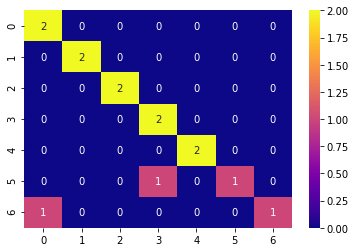

In [120]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='plasma')

In [121]:
accuracy_score(y_test, y_pred)

0.8571428571428571

In [122]:
recall_score(y_test, y_pred, average='macro')

0.8571428571428571

In [123]:
f1_score(y_test, y_pred, average='macro')

0.8476190476190476

## Apply Naive bayes to test dataset

In [125]:
y_pred = model.predict(test_vectors)

In [126]:
print(f'Accuracy = {accuracy_score(test.label, y_pred)}')
print(f"recall = {recall_score(test.label, y_pred, average='macro')}")
print(f"f1_score = {f1_score(test.label, y_pred, average='macro')}")


Accuracy = 0.9285714285714286
recall = 0.9285714285714286
f1_score = 0.9238095238095239


# Using KNN algorithm for classification

In [127]:
ks = [1,3,5,15]
for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k ,weights='distance',)
    knn_model.fit(x_train,y_train)
    y_pred = knn_model.predict(x_test)
    print(f'K = {k}')
    print(f'accuracy = {accuracy_score(y_test,y_pred)}')
    print(f"recall = {recall_score(y_test, y_pred, average='macro')}")
    print(f"f1_score = {f1_score(y_test, y_pred, average='macro')}")
    print(confusion_matrix(y_test,y_pred))
    
    print('----------')

K = 1
accuracy = 0.7857142857142857
recall = 0.7857142857142857
f1_score = 0.7333333333333334
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 1 0 1 0]
 [1 0 0 1 0 0 0]]
----------
K = 3
accuracy = 0.8571428571428571
recall = 0.8571428571428571
f1_score = 0.8571428571428571
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 1 0 1 0]
 [0 0 0 1 0 0 1]]
----------
K = 5
accuracy = 0.7857142857142857
recall = 0.7857142857142857
f1_score = 0.7238095238095238
[[2 0 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 1 0 0 1]
 [0 0 0 0 0 0 2]]
----------
K = 15
accuracy = 0.6428571428571429
recall = 0.6428571428571429
f1_score = 0.5673469387755102
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 2 0 0 0 0]
 [1 0 0 1 0 0 0]
 [0 0 0 0 2 0 0]
 [1 0 0 1 0 0 0]
 [1 0 0 1 0 0 0]]
----------


### Apply KNN with n_neighbors = 5 to test dataset

In [128]:
knn_model = KNeighborsClassifier(n_neighbors=5 ,weights='distance',)
knn_model.fit(train_vectors, train.label)

y_pred = knn_model.predict(test_vectors)

print(f'Accuracy = {accuracy_score(test.label, y_pred)}')
print(f"recall = {recall_score(test.label, y_pred, average='micro')}")
print(f"f1_score = {f1_score(test.label, y_pred, average='micro')}")


Accuracy = 0.9285714285714286
recall = 0.9285714285714286
f1_score = 0.9285714285714286


# Calculating TF-IDF for tokens

In [40]:
idf_tokens = defaultdict(int)
num_of_all_texts = train.shape[0] + test.shape[0]
for key,value in tokens.items() :
    idf = sum(train.text.apply(lambda text : 1 if key in text else 0 ))
    idf += sum(test.text.apply(lambda text : 1 if key in text else 0 ))
    idf = math.log10(num_of_all_texts / idf)
    
    idf_tokens[key] =  idf 

In [41]:
def replace_by_tfidf (vector) :
    l = []
    for key, value in zip(vector.index,vector.values) :
        l.append(value * idf_tokens[key])
    
    return l


train_labels = train_vectors.label
train_vectors = pd.DataFrame.from_records(train_vectors.drop('label',axis=1).apply(replace_by_tfidf,axis=1), columns= list(train_vectors.columns).remove('label'))
train_vectors['label'] = train_labels

test_labels = test_vectors.label
test_vectors = pd.DataFrame.from_records(test_vectors.drop('label', axis=1).apply(replace_by_tfidf, axis=1), columns = list(test_vectors.columns).remove('label'))
test_vectors['label'] = test_labels

In [42]:
x_train,x_test ,y_trian,y_test = train_test_split(train_vectors.drop('label', axis=1), train_vectors.label, test_size=0.3, \
                                                 random_state=101, stratify=train_vectors.label)

In [43]:
ks = [1,3,5,15]
for k in ks:
    knn_model = KNeighborsClassifier(n_neighbors=k )
    knn_model.fit(x_train,y_train)
    y_pred = knn_model.predict(x_test)
    print(f'K = {k}')
    print(f'accuracy = {accuracy_score(y_test,y_pred)}')
    print(f"recall = {recall_score(y_test, y_pred, average='macro')}")
    print(f"f1_score = {f1_score(y_test, y_pred, average='macro')}")
    print(confusion_matrix(y_test,y_pred))
    
    print('----------')

K = 1
accuracy = 0.47058823529411764
recall = 0.4761904761904762
f1_score = 0.3979591836734694
[[0 0 0 1 0 0 1]
 [0 0 0 2 0 0 1]
 [0 0 2 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 1 0 0 1]
 [0 0 0 2 0 0 1]]
----------
K = 3
accuracy = 0.35294117647058826
recall = 0.38095238095238093
f1_score = 0.35986394557823126
[[1 0 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 2 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 0 1 0 0 0 1]
 [0 0 2 0 0 0 1]]
----------
K = 5
accuracy = 0.23529411764705882
recall = 0.2857142857142857
f1_score = 0.2261904761904762
[[1 0 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 2 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 1 0 1 0 0]
 [0 0 1 0 0 0 1]
 [0 0 3 0 0 0 0]]
----------
K = 15
accuracy = 0.29411764705882354
recall = 0.2857142857142857
f1_score = 0.24761904761904763
[[0 0 0 0 0 0 2]
 [2 0 0 0 0 0 1]
 [0 0 1 0 0 0 1]
 [1 0 0 0 0 0 2]
 [0 0 0 0 1 0 1]
 [0 0 0 0 0 0 2]
 [0 0 0 0 0 0 3]]
----------


If set remove_stop_words parameter to **True** in *normalize_text* method we can see that performance of both KNN and naive bayes models will increase!

### Apply KNN with n_neighbors = 1  for test dataset

K = 15
accuracy = 0.42857142857142855
recall = 0.42857142857142855
f1_score = 0.38095238095238093


<AxesSubplot:>

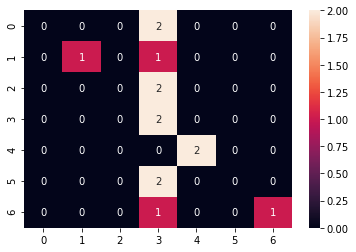

In [46]:
knn_model = KNeighborsClassifier(n_neighbors=1 )
knn_model.fit(x_train,y_train)
y_pred = knn_model.predict(test_vectors.drop('label', axis=1))
print(f'K = {k}')
print(f'accuracy = {accuracy_score(test_vectors.label,y_pred)}')
print(f"recall = {recall_score(test_vectors.label, y_pred, average='macro')}")
print(f"f1_score = {f1_score(test_vectors.label, y_pred, average='macro')}")
sns.heatmap(confusion_matrix(test_vectors.label,y_pred), annot=True)
